/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


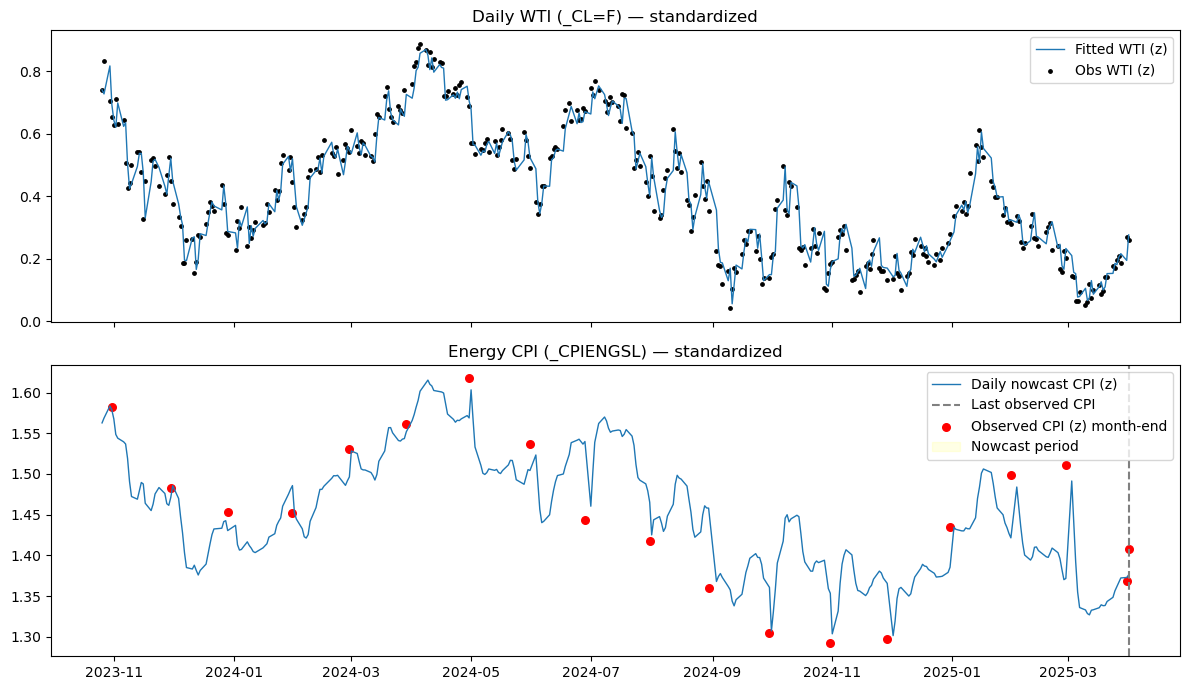


One-step-ahead forecast (z-score scale):
        WTI_z     CPI_z
360  0.265352  1.429752


/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [44]:
"""
biz_dfm_cl_cpi_zscore.py
------------------------
* _CL=F.csv        : 日次 WTI 先物（営業日ベース）
* _CPIENGSL.csv    : 月次エネルギー CPI（FRED 系フォーマット）

手順
1. 日次を営業日インデックスにリサンプル
2. 月次値を “月末営業日” の行にのみ配置
3. それぞれ Z スコア化して DataFrame 作成
4. DynamicFactorBizDM で推定
5. フィット値・ナウキャスト可視化＋次営業日 1 ステップ予測
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ


# --------------------------------------------------------------------
#  DynamicFactorBizDM   …… クラス本体は以前と変更なし
# --------------------------------------------------------------------
class DynamicFactorBizDM(DynamicFactorMQ):
    def __init__(self, endog: pd.DataFrame, k_endog_daily: int,
                 factors: int | list[int] = 1, factor_orders: int | list[int] = 1,
                 **kwargs):
        super().__init__(
            endog,
            k_endog_monthly=k_endog_daily,
            factors=factors,
            factor_orders=factor_orders,
            **kwargs,
        )

    def _init_aggregation_matrices(self):  # noqa: N802
        idx = self._index
        kD = self.k_endog_monthly
        kM = self.k_endog - kD
        #L = 31
        #k_states = self.factors * L

        k_states = self.ssm.k_states
        L = k_states // self.factors


        Z_t = np.zeros((self.k_endog, k_states, len(idx)))
        Z_t[:kD, 0, :] = 1.0                      # 日次：当日因子を 1

        month_groups = idx.to_series().groupby(idx.to_period("M"))
        for _, locs in month_groups.groups.items():
            N = len(locs)
            j = locs[-1]                          # 月末営業日の行番号
            row = np.zeros(k_states); row[:N] = 1.0 / N
            Z_t[kD:, :, j] = np.tile(row, (kM, 1))

        self.ssm["design"] = Z_t


# --------------------------------------------------------------------
def main():
    # 1. ファイルパス
    daily_path   = "_CL=F.csv"
    monthly_path = "_CPIENGSL.csv"

    # 2. データ読込
    wti_raw = pd.read_csv(daily_path)
    wti_raw["Date"] = pd.to_datetime(wti_raw["Date"])
    wti = wti_raw.set_index("Date").sort_index().iloc[:, 0]  # 先頭列 = 終値

    cpi_raw = pd.read_csv(monthly_path)
    cpi_raw["observation_date"] = pd.to_datetime(cpi_raw["observation_date"])
    cpi = cpi_raw.set_index("observation_date")["CPIENGSL"]

    # 3. 共通期間＋営業日インデックス
    start, end = max(wti.index.min(), cpi.index.min()), min(wti.index.max(), cpi.index.max())
    biz_idx = pd.bdate_range(start, end)

    wti_biz = wti.reindex(biz_idx)

    # 4. 月次値 → 月末営業日にだけ配置
    cpi_biz = pd.Series(index=biz_idx, dtype=float)
    for ts, val in cpi[start:end].items():
        per = ts.to_period("M")
        mask = biz_idx.to_period("M") == per
        if mask.any():
            cpi_biz.loc[biz_idx[mask][-1]] = val

    # 5. Z スコア化
    wti_z = (wti_biz - wti_biz.mean()) / wti_biz.std()
    cpi_z = (cpi_biz - cpi[start:end].mean()) / cpi[start:end].std()

    df = pd.DataFrame({"WTI_z": wti_z, "CPI_z": cpi_z}).dropna(how="all")
    df = df.iloc[-360:]

    # 6. モデル推定
    mod = DynamicFactorBizDM(df, k_endog_daily=1, factors=1, factor_orders=1)
    res = mod.fit(disp=False, maxiter=50)
    fitted = res.predict()

    # 7. 可視化
    last_obs_cpi = df["CPI_z"].dropna().index[-1]
    now_mask = fitted.index > last_obs_cpi

    fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

    axes[0].plot(fitted["WTI_z"], lw=1, label="Fitted WTI (z)")
    axes[0].scatter(df.index, df["WTI_z"], s=6, c="k", label="Obs WTI (z)")
    axes[0].set_title("Daily WTI (_CL=F) — standardized"); axes[0].legend()

    axes[1].plot(fitted["CPI_z"], lw=1, label="Daily nowcast CPI (z)")
    axes[1].scatter(df.index[df["CPI_z"].notna()], df["CPI_z"].dropna(),
                    c="r", s=30, label="Observed CPI (z) month-end")
    axes[1].axvline(last_obs_cpi, color="grey", ls="--", label="Last observed CPI")
    axes[1].fill_between(fitted.index, fitted["CPI_z"].min(), fitted["CPI_z"].max(),
                         where=now_mask, color="yellow", alpha=0.1,
                         label="Nowcast period")
    axes[1].set_title("Energy CPI (_CPIENGSL) — standardized")
    axes[1].legend()
    plt.tight_layout(); plt.show()

    # 8. 1 ステップ先予測 (z スケール)
    print("\nOne-step-ahead forecast (z-score scale):")
    print(res.forecast(steps=1))


if __name__ == "__main__":
    main()


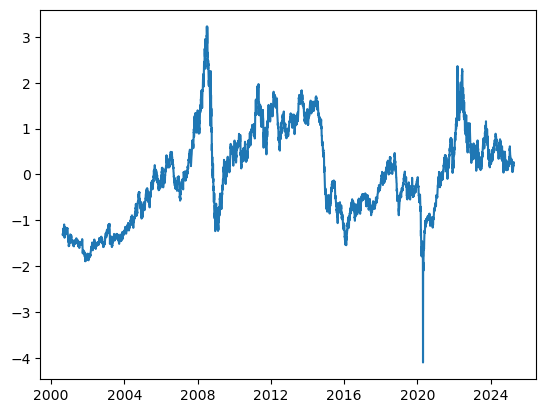

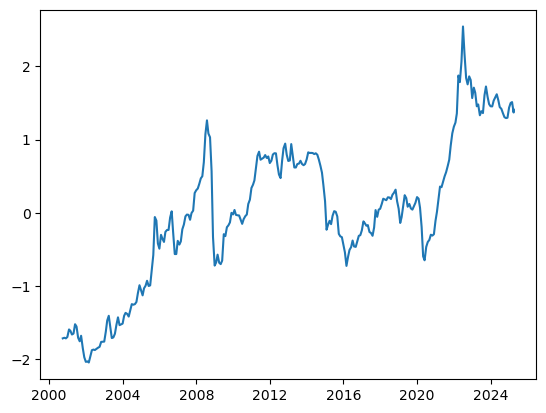

In [45]:
plt.plot(df.iloc[:,0])
plt.show()

plt.plot(df.dropna().iloc[:,1])
plt.show()

In [46]:
df

,WTI_z,CPI_z
2000-08-23,-1.309757,NaN
2000-08-24,-1.326590,NaN
2000-08-25,-1.309757,NaN
2000-08-28,-1.276891,NaN
2000-08-29,-1.282903,NaN
...,...,...
2025-03-26,0.197252,NaN
2025-03-27,0.208073,NaN
2025-03-28,0.185628,NaN
2025-03-31,0.270598,1.368804


In [47]:
df.iloc[-200:].head(32)

,WTI_z,CPI_z
2024-06-14,0.549956,NaN
2024-06-17,0.625306,NaN
2024-06-18,0.675005,NaN
2024-06-20,0.699053,NaN
2024-06-21,0.641338,NaN
2024-06-24,0.677410,NaN
2024-06-25,0.645346,NaN
2024-06-26,0.648152,NaN
2024-06-27,0.681819,NaN
2024-06-28,0.673803,1.443221


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
import yfinance as yf

In [32]:
df_daily = pd.read_csv("CL=F.csv", parse_dates=["Date"]).set_index("Date").sort_index()
df_monthly = pd.read_csv("CPIENGSL.csv", parse_dates=["observation_date"]).rename({"observation_date": "Date"}, axis="columns").set_index("Date").sort_index()
df_monthly.index = df_monthly.index.to_period("M")

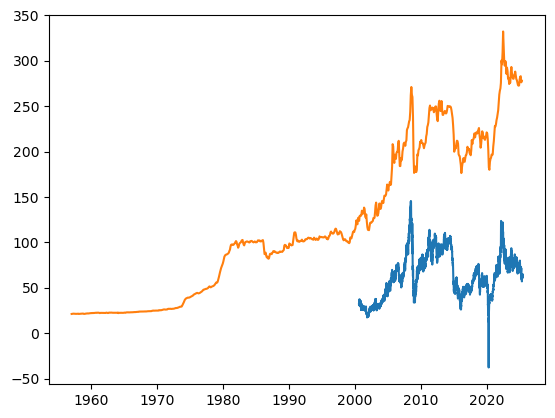

In [39]:
plt.plot(df_daily)
plt.plot(df_monthly)
plt.show()

In [40]:
daily_ret   = np.log(df_daily['CL=F']).diff().dropna() * 100
monthly_mom = df_monthly['CPIENGSL'].pct_change().dropna() * 100

daily_ret = daily_ret.asfreq('B').ffill()
monthly_ts = monthly_mom.to_timestamp('M')

daily_z   = (daily_ret   - daily_ret.mean())   / daily_ret.std(ddof=0)
monthly_z = (monthly_mom - monthly_mom.mean()) / monthly_mom.std(ddof=0)

/Users/K/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


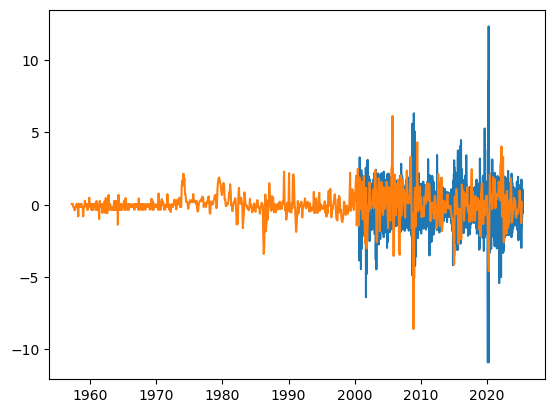

In [41]:
plt.plot(daily_z)
plt.plot(monthly_z)
plt.show()

In [42]:
idx = pd.date_range(daily_z.index.min(), daily_z.index.max(), freq='B')
daily_mat   = daily_z.reindex(idx)
monthly_mat = monthly_z.to_timestamp('M').reindex(idx)

df_daily   = daily_mat.to_frame(name='WTI_ret')
df_monthly = monthly_mat.to_frame(name='CPI_Energy_MoM')

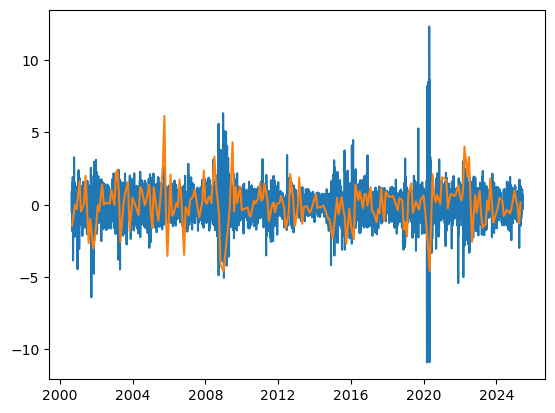

In [48]:
plt.plot(df_daily)
plt.plot(df_monthly.dropna())
plt.show()

In [66]:
"""
dynamic_factor_dm.py
--------------------
日次(D) / 月次(M) 混合頻度 Dynamic Factor Model for statsmodels.

* 先頭 k_endog_daily 列 … 日次観測 (欠損なし想定、祝日欠損は NaN で可)
* 残り          … 月次観測 (月末だけ値、ほか NaN)

元クラス: statsmodels.tsa.statespace.dynamic_factor_mq.DynamicFactorMQ
----------------------------------------------------------------------
"""

from __future__ import annotations
import calendar
import numpy as np
import pandas as pd

from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ


class DynamicFactorDM(DynamicFactorMQ):
    """
    Dynamic Factor Mixed-Frequency model (Daily / Monthly version).

    Parameters
    ----------
    endog : pd.DataFrame
        日次インデックス。最初 ``k_endog_daily`` 列が日次系列、
        それ以外は月次系列 (月末のみ値、その他 NaN)。
    k_endog_daily : int
        日次系列の本数。
    factors, factor_orders, idiosyncratic_ar1, factor_multiplicative : \
        DynamicFactorMQ と同じ。
    """

    def __init__(
        self,
        endog: pd.DataFrame,
        k_endog_daily: int,
        factors: int | list[int],
        factor_orders: int | list[int],
        idiosyncratic_ar1: bool = False,
        factor_multiplicative: bool = False,
        **kwargs,
    ):
        # DynamicFactorMQ の引数名は "k_endog_monthly" (=高頻度) なので
        #   → 日次列数をそのまま渡す
        super().__init__(
            endog,
            k_endog_monthly=k_endog_daily,
            factors=factors,
            factor_orders=factor_orders,
            idiosyncratic_ar1=idiosyncratic_ar1,
            factor_multiplicative=factor_multiplicative,
            **kwargs,
        )

    # ------------------------------------------------------------------
    # ★   月次系列の「月平均」集計行列 K_t を作り直す                   ★
    # ------------------------------------------------------------------
    def _init_aggregation_matrices(self) -> None:  # noqa: N802 (元メソッド名)
        """
        Build aggregation matrix K_t for each observation t.

        月次観測は
            y_M(t_month_end) = (1/N_m) Σ_{d∈月}  f_d  + ε_t
        となるので、month ごとに N_m(=その月の日数) を変える。
        """
        # ---- 準備 -----------------------------------------------------
        idx = self._index                           # pd.DatetimeIndex (日次)
        L = max(calendar.monthrange(ts.year, ts.month)[1] for ts in idx)  # 31
        k_endog_M = self.k_endog_quarterly          # (=月次列数)
        k_states   = self.ssm.k_states              # = factors * L

        # selection マトリクス (日次観測用: 当日の因子のみ 1)
        K_daily = np.zeros((self.k_endog_monthly, k_states))
        for r in range(self.k_endog_monthly):
            K_daily[r, r * L] = 1.0                 # 先頭ラグ位置

        # ---- 各 t ごとに Z_t (design) を組み立て ----------------------
        Z_t = np.zeros((self.k_endog, k_states, len(idx)))

        # 1) 日次パート: 毎日同じ
        Z_t[: self.k_endog_monthly, :, :] = K_daily[:, :, None]

        # 2) 月次パート: 月単位で平均を取る
        pos_M = slice(self.k_endog_monthly, self.k_endog)  # 行インデックス
        month_id = idx.to_period("M")

        for t, ts in enumerate(idx):
            if np.isnan(self.endog.iloc[t, pos_M]).all():
                # 月次欠損行 → ゼロ行のまま (観測しない)
                continue

            # その月の日数と「月末からの距離 d」計算
            last_day = ts.to_period("M").to_timestamp("M")
            days_in_month = (last_day.to_period("D").end_time.to_pydatetime().day)
            # 末端ラグから 0 … -(days_in_month-1)
            lag_idx = np.arange(days_in_month)[::-1]

            # 係数 1/N_m をラグごとに配置
            row = np.zeros(k_states)
            row[lag_idx] = 1.0 / days_in_month
            Z_t[pos_M, :, t] = np.tile(row, (k_endog_M, 1))

        # statsmodels レイヤに渡す
        self.ssm['design'] = Z_t

    # ------------------------------------------------------------------
    # その他のステップは元クラスの EM / Kalman フィルタをそのまま使用。
    # ------------------------------------------------------------------


# ----------------------------------------------------------------------
# 使い方サンプル
# ----------------------------------------------------------------------
if __name__ == "__main__":
    # シンプルサンプル：日次 ×1列 + 月次 ×1列
    import matplotlib.pyplot as plt

    np.random.seed(0)
    dates = pd.date_range("2024-01-01", "2024-12-31", freq="D")
    n = len(dates)

    f_true = np.cumsum(np.random.randn(n))
    yD = f_true + 0.1 * np.random.randn(n)

    yM = pd.Series(index=dates, dtype=float)
    for ts, v in pd.Series(f_true, index=dates).resample("M").mean().items():
        yM.loc[ts] = v + 0.2 * np.random.randn()

    df = pd.DataFrame({"yD": yD, "yM": yM})

    mod = DynamicFactorDM(df, k_endog_daily=1, factors=1, factor_orders=1)
    res = mod.fit(disp=False)

    #plt.plot(res.factors.smoothed.iloc[:, 0], label="Smoothed factor")
    #plt.plot(dates, f_true, "--", label="True factor")
    #plt.legend(); plt.title("DynamicFactorDM result"); plt.show()


/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['factor_multiplicative']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:2655: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


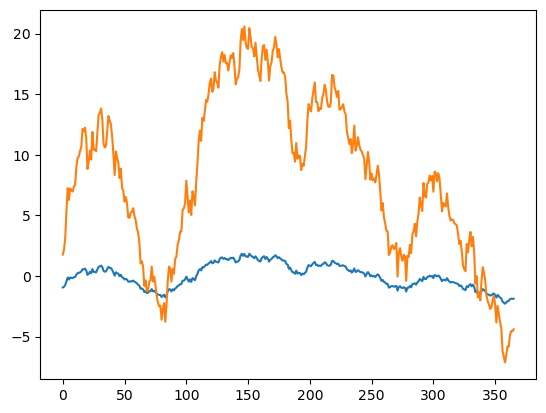

In [71]:
plt.plot(res.factors.smoothed.iloc[:, 0].values)
plt.plot(f_true)
plt.show()

In [72]:
fitted = res.predict()

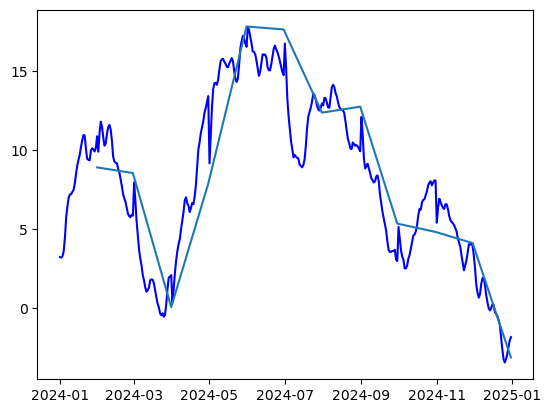

In [97]:
plt.plot(fitted.iloc[:,1], color="blue")
#plt.plot(fitted.index.values, yD, color="orange")
plt.plot(yM.dropna())
plt.show()

In [98]:
"""
dynamic_factor_dm_biz.py
------------------------
*statsmodels* 標準の **DynamicFactorMQ** を「高頻度＝日次・低頻度＝月次」に
流用するためのサブクラスと、  
**営業日ベース** の日次系列を扱う完全サンプル。

● 主なポイント
------------------------------------------------------------------
1. **週末・祝日欠損を NaN のまま** カレンダー日に再インデックス  
   → 状態ベクトル長 31 を維持し、既存アルゴリズムをそのまま利用  
2. 月次観測は「月末**営業日**」にのみ値を入れる  
3. `res.predict()` で得られるフィット値は  
   - 日次列 : in-sample fitted  
   - 月次列 : **営業日ごとのナウキャスト** （月末実測セルでは誤差 0）

------------------------------------------------------------------
動かすには
  $ pip install statsmodels pandas_market_calendars matplotlib
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import calendar
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ


# ------------------------------------------------------------------
# 1. クラス定義（最小限のオーバーライド）
# ------------------------------------------------------------------
class DynamicFactorDM(DynamicFactorMQ):
    """
    Dynamic-Factor Mixed-Frequency  (Daily ↔ Monthly).

    Parameters
    ----------
    endog : pd.DataFrame
        インデックス = **連続カレンダー日**。先頭 k_endog_daily 列が日次観測、
        残りが月次観測（値は「月末営業日だけ」入れ、他は NaN）。
    k_endog_daily : int
        日次観測の本数。
    """

    # コンストラクタ: 引数名だけ読み替え
    def __init__(
        self,
        endog: pd.DataFrame,
        k_endog_daily: int,
        factors: int | list[int] = 1,
        factor_orders: int | list[int] = 1,
        idiosyncratic_ar1: bool = False,
        factor_multiplicative: bool = False,
        **kwargs,
    ):
        super().__init__(
            endog,
            k_endog_monthly=k_endog_daily,   # ←日次列を "monthly" 扱い
            factors=factors,
            factor_orders=factor_orders,
            idiosyncratic_ar1=idiosyncratic_ar1,
            factor_multiplicative=factor_multiplicative,
            **kwargs,
        )

    # 月次平均行列 K_t を「月の日数 31」で割る（週末込み平均）
    # ※ 週末・祝日は latent factor だけが存在（観測なし）
    def _init_aggregation_matrices(self):  # noqa: N802
        idx = self._index
        T = len(idx)
        L = 31                               # ラグ長は固定（最長月）
        k_states = self.factors * L
        k_endog_D = self.k_endog_monthly
        k_endog_M = self.k_endog - k_endog_D

        # ---- 日次デザイン（直近ラグ = 0） ---------------------------
        Z_t = np.zeros((self.k_endog, k_states, T))
        for r in range(k_endog_D):
            Z_t[r, 0, :] = 1.0               # f_t

        # ---- 月次デザイン（1/日数 ずつ） ----------------------------
        pos_M = slice(k_endog_D, self.k_endog)
        month_ends = idx.to_period("M").groupby(idx.to_period("M")).idxmax()

        for t_end in month_ends:
            t = idx.get_loc(t_end)           # 月末営業日の行番号
            month = t_end.to_period("M")
            days_in_month = calendar.monthrange(month.year, month.month)[1]
            # 平均係数をラグ 0〜(days_in_month-1) に配置
            row = np.zeros(k_states)
            row[:days_in_month] = 1.0 / days_in_month
            Z_t[pos_M, :, t] = np.tile(row, (k_endog_M, 1))

        self.ssm["design"] = Z_t

    # ---- 便利ヘルパ --------------------------------------------------
    def fittedvalues_full(self) -> pd.DataFrame:
        """欠損補完後のフィット値（= predict()）を返す"""
        return self._results.predict()

    def nowcast_lowfreq(self) -> pd.DataFrame:
        """月次系列の日次ナウキャストだけ返す"""
        fitted = self._results.predict()
        return fitted.iloc[:, self.k_endog_monthly :]


# ------------------------------------------------------------------
# 2. 営業日→カレンダー日 reindex ヘルパ
# ------------------------------------------------------------------
def to_calendar(df_biz: pd.DataFrame) -> pd.DataFrame:
    full_idx = pd.date_range(df_biz.index.min(), df_biz.index.max(), freq="D")
    return df_biz.reindex(full_idx)


# ------------------------------------------------------------------
# 3. デモ: 日本取引所 (JPX) カレンダーでシミュレーション
# ------------------------------------------------------------------
def main():
    # -- 3.1 営業日インデックス (JPX) -------------------------------
    jpx = mcal.get_calendar("JPX")
    biz_idx = jpx.schedule("2024-01-01", "2024-12-31").index

    # -- 3.2 カレンダー日 latent factor (RW1) -----------------------
    full_idx = pd.date_range("2024-01-01", "2024-12-31", freq="D")
    np.random.seed(7)
    factor = pd.Series(np.cumsum(np.random.randn(len(full_idx))), index=full_idx)

    # -- 3.3 観測生成 -----------------------------------------------
    yD = factor.loc[biz_idx] + 0.1 * np.random.randn(len(biz_idx))

    # 月次観測 = カレンダー平均 + ノイズ、月末 “営業日” にだけ入れる
    yM = pd.Series(index=biz_idx, dtype=float)
    for per, val in factor.resample("M").mean().items():
        last_bd = biz_idx[biz_idx.to_period("M") == per][-1]
        yM.loc[last_bd] = val + 0.2 * np.random.randn()

    df_biz = pd.DataFrame({"yD": yD, "yM": yM})
    df = to_calendar(df_biz)                # 週末を NaN で埋める

    # -- 3.4 モデル推定 ---------------------------------------------
    mod = DynamicFactorDM(df, k_endog_daily=1, factors=1, factor_orders=1)
    res = mod.fit(disp=False)

    # -- 3.5 フィット値 & ナウキャスト -------------------------------
    fitted = res.predict()                  # 全列・全日付
    yM_nowcast = fitted["yM"]               # 月次ナウキャスト

    # -- 3.6 可視化 --------------------------------------------------
    plt.figure(figsize=(11, 4))
    plt.plot(fitted["yD"], lw=1, label="Fitted yD")
    plt.scatter(df.index[df["yD"].notna()],
                df.loc[df["yD"].notna(), "yD"],
                s=15, color="k", marker=".", label="Observed yD")
    plt.title("Daily series: observed vs. fitted")
    plt.legend(); plt.tight_layout()

    plt.figure(figsize=(11, 4))
    plt.plot(yM_nowcast, lw=1, label="Daily nowcast yM")
    plt.scatter(df.index[df["yM"].notna()],
                df.loc[df["yM"].notna(), "yM"],
                s=40, color="r", marker="o", label="Observed yM (EOM)")
    plt.title("Monthly series: daily nowcasts vs. EOM observations")
    plt.legend(); plt.tight_layout()
    plt.show()

    # -- 3.7 1 ステップ先予測例 --------------------------------------
    print("\nNext-day forecast:")
    print(res.forecast(steps=1))


if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'pandas_market_calendars'

In [96]:
fitted

,yD,yM
2024-01-01,1.744987,3.227499
2024-01-02,1.793623,3.198562
2024-01-03,2.170470,3.271255
2024-01-04,3.154372,3.611566
2024-01-05,5.292835,4.482295
...,...,...
2024-12-27,-5.803114,-3.242413
2024-12-28,-5.583418,-2.939392
2024-12-29,-4.701399,-2.475099
2024-12-30,-4.386392,-2.066701


/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['factor_multiplicative']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


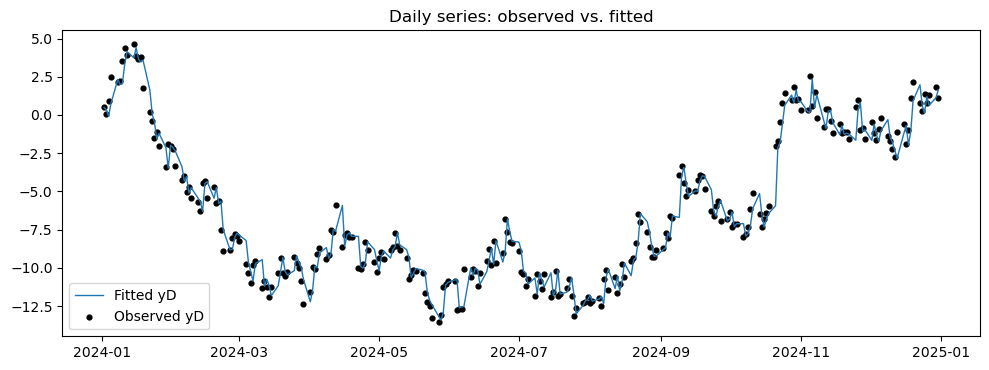

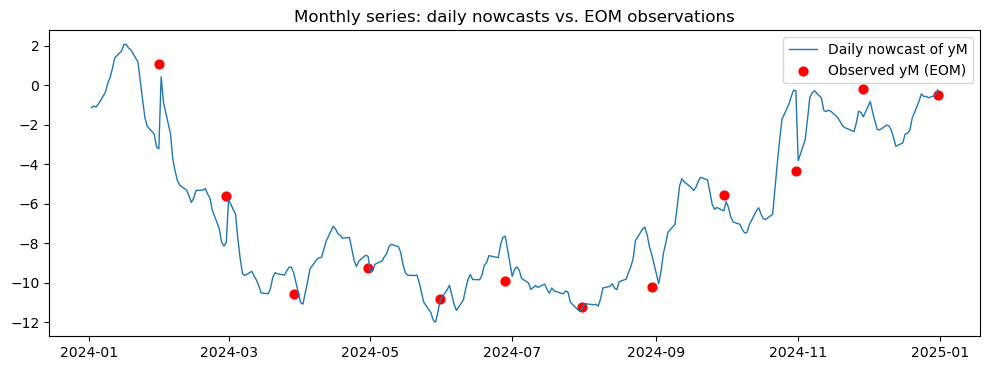


One-step-ahead forecast:
                  yD        yM
2025-01-01  0.954019 -0.440955


In [100]:
# ---------------------------------------------------------------------
#  DynamicFactorBizDM  ―  「営業日インデックス × 月次」専用ラッパ
# ---------------------------------------------------------------------
#  * statsmodels.tsa.statespace.dynamic_factor_mq.DynamicFactorMQ を継承
#  * インデックスは **営業日系列（freq='B' や JPX 営業日など）** に限定
#  * 週末・祝日を含む“カレンダー日”への再インデックスは **一切不要**
#
#  変更点はたった 2 か所
#    (1) コンストラクタ: k_endog_daily → k_endog_monthly にそのまま渡す
#    (2) _init_aggregation_matrices:
#        月次観測を「その月の営業日 N で平均」する Z_t を構築
#
# ---------------------------------------------------------------------
import numpy as np
import pandas as pd
import calendar
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ


class DynamicFactorBizDM(DynamicFactorMQ):
    """
    Dynamic Factor Mixed-Frequency (Daily(biz) ↔ Monthly).

    Parameters
    ----------
    endog : pd.DataFrame
        インデックスは営業日だけ。最初 k_endog_daily 列が日次観測、
        残りが月次観測（値は「月末営業日」にのみ入り、他は NaN）。
    k_endog_daily : int
        日次観測の列数。
    """

    # --- (1) コンストラクタ -----------------------------------------
    def __init__(
        self,
        endog: pd.DataFrame,
        k_endog_daily: int,
        factors: int | list[int] = 1,
        factor_orders: int | list[int] = 1,
        idiosyncratic_ar1: bool = False,
        factor_multiplicative: bool = False,
        **kwargs,
    ):
        super().__init__(
            endog,
            k_endog_monthly=k_endog_daily,   # “高頻度”列として渡す
            factors=factors,
            factor_orders=factor_orders,
            idiosyncratic_ar1=idiosyncratic_ar1,
            factor_multiplicative=factor_multiplicative,
            **kwargs,
        )

    # --- (2) 低頻度（月次）集計行列 Z_t を上書き --------------------
    def _init_aggregation_matrices(self):  # noqa: N802 (元メソッド名)
        idx = self._index                                # 営業日 DatetimeIndex
        T = len(idx)

        # 状態ベクトル長 L は既定 (=31) のまま利用
        k_states = self.ssm.k_states
        L = k_states // self.factors

        kD = self.k_endog_monthly                        # 日次列数
        kM = self.k_endog - kD                           # 月次列数
        pos_M = slice(kD, self.k_endog)                  # 月次行インデックス

        # デザイン行列 Z_t (k_endog × k_states × T)
        Z_t = np.zeros((self.k_endog, k_states, T))

        # ---- 日次パート: 当日ファクターをそのまま観測 ---------------
        for r in range(kD):
            Z_t[r, 0, :] = 1.0                           # lag 0

        # ---- 月次パート: 月末営業日だけ行をセット -------------------
        #  month_groups : {Period('2024-01', 'M'): [行番号, …], …}
        month_groups = idx.to_series().groupby(idx.to_period("M"))

        for per, positions in month_groups.groups.items():
            N = len(positions)                           # 当月の営業日数
            t_last = positions[-1]                       # 月末営業日の行
            row = np.zeros(k_states)
            row[:N] = 1.0 / N                            # 1/N 平均
            Z_t[pos_M, :, t_last] = np.tile(row, (kM, 1))

        # 既存 SSModel に注入
        self.ssm["design"] = Z_t

    # ------- 便利メソッド -------------------------------------------
    def fittedvalues_full(self) -> pd.DataFrame:
        """観測欠損を補完した in-sample フィット値"""
        return self._results.predict()

    def nowcast_lowfreq(self) -> pd.Series | pd.DataFrame:
        """月次列の営業日日次ナウキャスト"""
        fit = self._results.predict()
        return fit.iloc[:, self.k_endog_monthly:]


# ---------------------------------------------------------------------
#  デモ: 営業日インデックスのみで推定
# ---------------------------------------------------------------------
if __name__ == "__main__":
    # 1. 営業日インデックスを作成（ここでは Mon-Fri = pandas freq 'B'）
    biz_idx = pd.bdate_range("2024-01-02", "2024-12-31")   # JP 祝日は無視

    # 2. 真の共通ファクター (ランダムウォーク) を営業日に合わせて生成
    np.random.seed(42)
    f_true = pd.Series(np.cumsum(np.random.randn(len(biz_idx))), index=biz_idx)

    # 3. 観測値を生成
    yD = f_true + 0.1 * np.random.randn(len(biz_idx))      # 日次列

    yM = pd.Series(index=biz_idx, dtype=float)
    for ts, mean_val in f_true.resample("M").mean().items():
        per = ts.to_period("M")                # Timestamp → Period[M]
        mask = biz_idx.to_period("M") == per   # 同じ型で比較
        if mask.any():
            last_bd = biz_idx[mask][-1]
            yM.loc[last_bd] = mean_val + 0.2 * np.random.randn()
            
    df = pd.DataFrame({"yD": yD, "yM": yM})

    # 4. モデル推定
    mod = DynamicFactorBizDM(df, k_endog_daily=1, factors=1, factor_orders=1)
    res = mod.fit(disp=False)

    # 5. フィット値と月次ナウキャスト
    fitted = res.predict()         # df と同じ形
    yM_nowcast = fitted["yM"]

    # 6. 可視化
    plt.figure(figsize=(10, 3.8))
    plt.plot(fitted["yD"], lw=1, label="Fitted yD")
    plt.scatter(df.index, df["yD"], s=12, c="k", label="Observed yD")
    plt.title("Daily series: observed vs. fitted"); plt.legend(); plt.tight_layout()

    plt.figure(figsize=(10, 3.8))
    plt.plot(yM_nowcast, lw=1, label="Daily nowcast of yM")
    plt.scatter(df.index[df["yM"].notna()],
                df.loc[df["yM"].notna(), "yM"],
                c="r", s=40, marker="o", label="Observed yM (EOM)")
    plt.title("Monthly series: daily nowcasts vs. EOM observations")
    plt.legend(); plt.tight_layout(); plt.show()

    # 7. 翌営業日の 1 ステップ先予測
    print("\nOne-step-ahead forecast:")
    print(res.forecast(steps=1))


In [102]:
df.head(30)

,yD,yM
2024-01-02,0.490762,NaN
2024-01-03,0.034323,NaN
2024-01-04,0.903700,NaN
2024-01-05,2.503911,NaN
2024-01-08,2.170237,NaN
2024-01-09,2.224119,NaN
2024-01-10,3.497077,NaN
2024-01-11,4.363521,NaN
2024-01-12,3.951125,NaN
2024-01-15,4.624738,NaN


/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


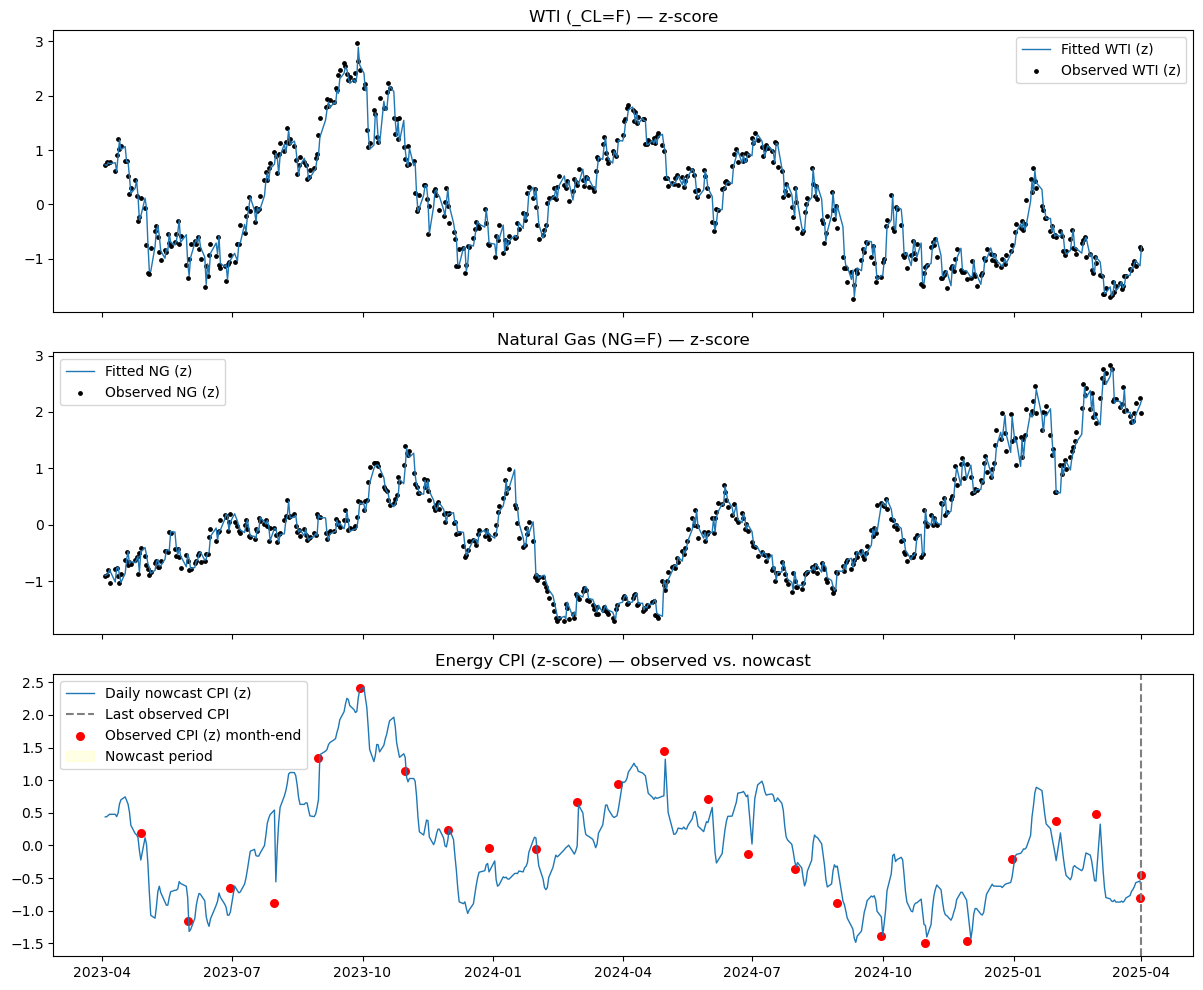


One-step-ahead forecast (z-score scale):
        WTI_z     NG_z     CPI_z
504 -0.827234  1.94487 -0.189112


/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [72]:
"""
biz_dfm_wti_ng_cpi_twofactor.py
--------------------------------
日次 2 本（WTI = _CL=F.csv, 天然ガス = NG=F.csv）  
＋ 月次 1 本（エネルギー CPI = _CPIENGSL.csv）を

    DynamicFactorBizDM（営業日 × 月次）  
    └ factors = 2, factor_orders = 1

で推定・可視化するフルスクリプト  
（DynamicFactorBizDM クラス本体は **一切変更なし**。  
 直近 2 年のデータだけを使い、メモリ抑制）

* ファイルは `/mnt/data/` 直下にある想定。
  - `/mnt/data/_CL=F.csv`
  - `/mnt/data/NG=F.csv`
  - `/mnt/data/_CPIENGSL.csv`
  （名前が異なる場合は `daily_path_*` / `monthly_path` を書き換えて下さい）
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ


# -------------------------------------------------------------------
#  変更無しの DynamicFactorBizDM（営業日インデックス × 月次）
# -------------------------------------------------------------------
class DynamicFactorBizDM(DynamicFactorMQ):
    def __init__(self, endog: pd.DataFrame, k_endog_daily: int,
                 factors: int | list[int] = 1, factor_orders: int | list[int] = 1,
                 **kwargs):
        super().__init__(
            endog,
            k_endog_monthly=k_endog_daily,   # 高頻度列 = 日次列
            factors=factors,
            factor_orders=factor_orders,
            **kwargs,
        )

    def _init_aggregation_matrices(self):  # noqa: N802
        idx = self._index
        kD = self.k_endog_monthly
        kM = self.k_endog - kD
        L = 31                              # ラグ長 (固定)
        k_states = self.factors * L

        Z_t = np.zeros((self.k_endog, k_states, len(idx)))
        Z_t[:kD, 0, :] = 1.0                # 日次行 (lag0)

        month_groups = idx.to_series().groupby(idx.to_period("M"))
        for _, locs in month_groups.groups.items():
            N = len(locs)
            j = locs[-1]                    # 月末営業日の行番号
            row = np.zeros(k_states); row[:N] = 1.0 / N
            Z_t[kD:, :, j] = np.tile(row, (kM, 1))

        self.ssm["design"] = Z_t


# -------------------------------------------------------------------
#  ヘルパ：CSV から日次シリーズを読み込み → Series[Date]
# -------------------------------------------------------------------
def load_daily_series(path: str) -> pd.Series:
    df = pd.read_csv(path)
    date_col = "Date" if "Date" in df.columns else df.columns[0]
    df[date_col] = pd.to_datetime(df[date_col])
    series = df.set_index(date_col).sort_index().iloc[:, 0]
    return series


# -------------------------------------------------------------------
def main():
    # ---------- ファイルパス ---------------------------------------
    wti_path  = "_CL=F.csv"
    ng_path   = "NG=F.csv"
    cpi_path  = "_CPIENGSL.csv"

    # ---------- 1. データ読込 --------------------------------------
    wti = load_daily_series(wti_path)
    ng  = load_daily_series(ng_path)

    cpi_raw = pd.read_csv(cpi_path)
    cpi_raw["observation_date"] = pd.to_datetime(cpi_raw["observation_date"])
    cpi = cpi_raw.set_index("observation_date")["CPIENGSL"]

    # ---------- 2. 期間合わせ（直近 2 年）＆営業日インデックス -------
    end   = min(wti.index.max(), ng.index.max(), cpi.index.max())
    start = end - pd.DateOffset(years=2)
    biz_idx = pd.bdate_range(start, end)

    wti_biz = wti.reindex(biz_idx)
    ng_biz  = ng.reindex(biz_idx)

    # 月次値 → 月末営業日にだけ配置
    cpi_biz = pd.Series(index=biz_idx, dtype=float)
    for ts, val in cpi[start:end].items():
        per = ts.to_period("M")
        mask = biz_idx.to_period("M") == per
        if mask.any():
            cpi_biz.loc[biz_idx[mask][-1]] = val

    # ---------- 3. Z スコア化 --------------------------------------
    wti_z = (wti_biz - wti_biz.mean()) / wti_biz.std()
    ng_z  = (ng_biz  -  ng_biz.mean()) /  ng_biz.std()
    cpi_z = (cpi_biz - cpi[start:end].mean()) / cpi[start:end].std()

    df = pd.DataFrame({"WTI_z": wti_z, "NG_z": ng_z, "CPI_z": cpi_z}).dropna(how="all")

    # ---------- 4. 2 ファクター DynamicFactorBizDM 推定 -----------
    mod = DynamicFactorBizDM(df, k_endog_daily=2, factors=2, factor_orders=1)
    res = mod.fit(disp=False, maxiter=60)
    fitted = res.predict()

    # ---------- 5. 可視化 ------------------------------------------
    last_obs_cpi = df["CPI_z"].dropna().index[-1]
    now_mask = fitted.index > last_obs_cpi

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    axes[0].plot(fitted["WTI_z"], lw=1, label="Fitted WTI (z)")
    axes[0].scatter(df.index, df["WTI_z"], s=6, c="k", label="Observed WTI (z)")
    axes[0].set_title("WTI (_CL=F) — z-score"); axes[0].legend()

    axes[1].plot(fitted["NG_z"], lw=1, label="Fitted NG (z)")
    axes[1].scatter(df.index, df["NG_z"], s=6, c="k", label="Observed NG (z)")
    axes[1].set_title("Natural Gas (NG=F) — z-score"); axes[1].legend()

    axes[2].plot(fitted["CPI_z"], lw=1, label="Daily nowcast CPI (z)")
    axes[2].scatter(df.index[df["CPI_z"].notna()], df["CPI_z"].dropna(),
                    c="r", s=30, label="Observed CPI (z) month-end")
    axes[2].axvline(last_obs_cpi, color="grey", ls="--", label="Last observed CPI")
    axes[2].fill_between(fitted.index, fitted["CPI_z"].min(), fitted["CPI_z"].max(),
                         where=now_mask, color="yellow", alpha=0.1,
                         label="Nowcast period")
    axes[2].set_title("Energy CPI (z-score) — observed vs. nowcast")
    axes[2].legend()

    plt.tight_layout(); plt.show()

    # ---------- 6. 次営業日の 1 ステップ予測 ------------------------
    print("\nOne-step-ahead forecast (z-score scale):")
    print(res.forecast(steps=1))


if __name__ == "__main__":
    main()


In [73]:
factors_smoothed = res.factors.smoothed
factors_smoothed

/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2999: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2999: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2999: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2999: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported in

,0
0,5.147435e+16
1,5.142085e+16
2,5.140067e+16
3,5.137879e+16
4,5.121069e+16
...,...
6182,3.380202e+15
6183,1.365710e+15
6184,-2.930903e+15
6185,1.107197e+16


In [63]:
# smoothed state vector (T x total number of states)
smoothed_states = res.smoothed_state.T  # shape (T, n_states)

# filtered state vector
filtered_states = res.filtered_state.T


In [64]:
# 例: 最初の k_factors 成分が latent factors
k_factors = mod.k_factors

# smoothed factor series
factors_smoothed = smoothed_states[:, :k_factors]  # shape (T, k_factors)

# filtered factor series
factors_filtered = filtered_states[:, :k_factors]


/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2999: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2999: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2999: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2999: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported in

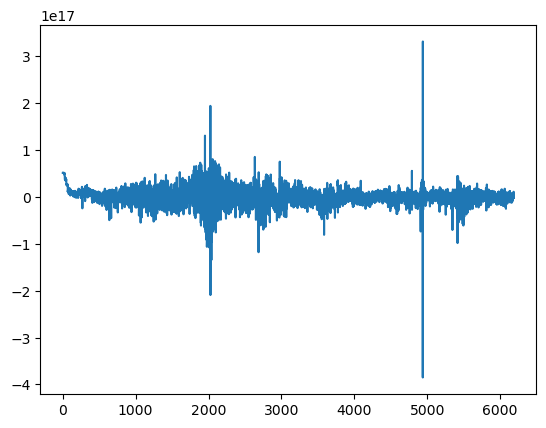

In [71]:
plt.plot(res.factors.smoothed)
plt.show()

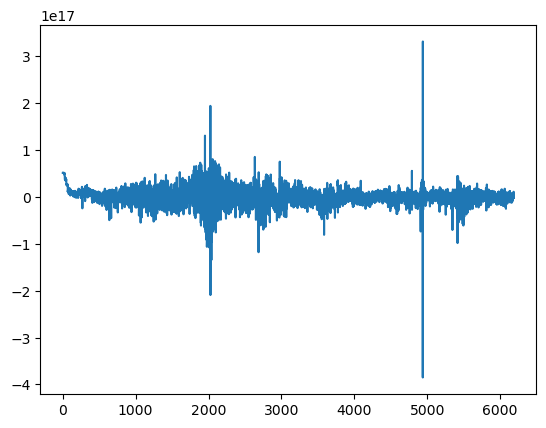

In [66]:
plt.plot(factors_smoothed)
plt.show()

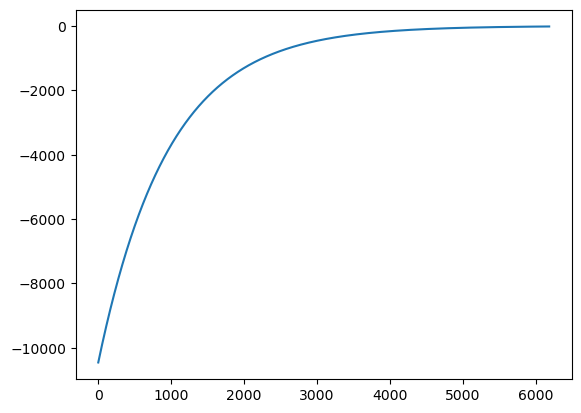

In [67]:
plt.plot(factors_filtered)
plt.show()

/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2999: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2999: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2999: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported in


Smoothed factors saved → estimated_factors.csv
First 10 rows:
           0         1
0 -1.148058 -0.207844
1 -1.172891 -0.131264
2 -1.107029 -0.059064
3 -1.276525 -0.313185
4 -0.984454 -0.205601
5 -1.183086  0.188516
6 -1.492436  0.367762
7 -1.455769 -0.020970
8 -1.380984  0.255496
9 -1.001641  0.213153 



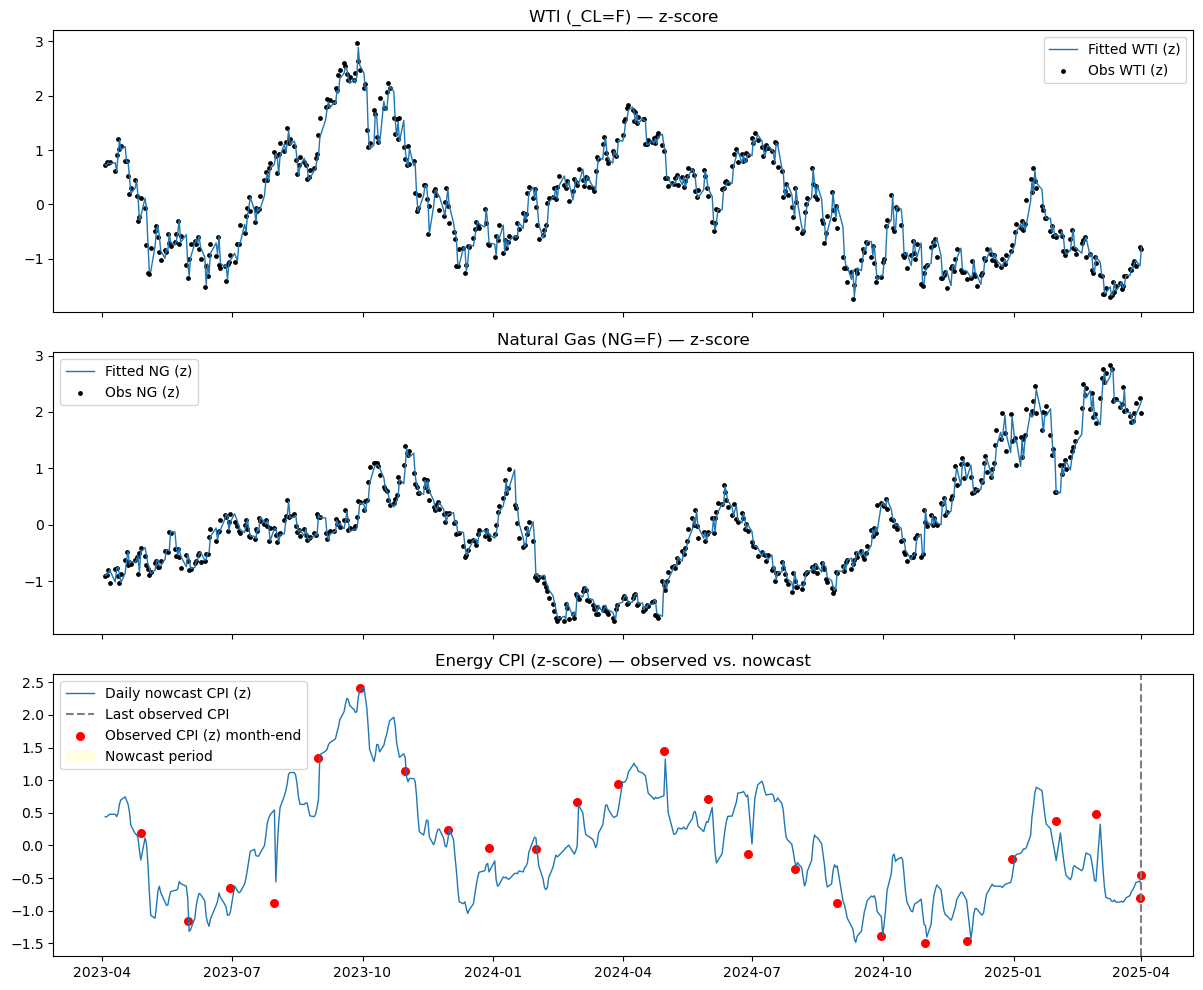

One-step-ahead forecast (z-score scale):
        WTI_z     NG_z     CPI_z
504 -0.827234  1.94487 -0.189112


/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/K/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [74]:
"""
biz_dfm_wti_ng_cpi_twofactor_factors.py
---------------------------------------
WTI (_CL=F.csv)・天然ガス (NG=F.csv) を 2 本の日次系列、  
エネルギー CPI (_CPIENGSL.csv) を月次系列として

    DynamicFactorBizDM (営業日 × 月次, 2 factors)

で推定し、

1. フィット／ナウキャストを可視化  
2. **平滑化ファクター系列 (smoothed) を取得・保存**  

※ クラス本体は変更せず、前処理のみ調整。
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ


# -------------------------------------------------------------------
#  ドメイン固有設定：直近 2 年に期間を絞るとメモリ節約になる
# -------------------------------------------------------------------
YEARS_BACK = 2          # ここを変えれば対象期間を変更可
DAILY_PATH_WTI = "_CL=F.csv"
DAILY_PATH_NG  = "NG=F.csv"
MONTHLY_PATH_CPI = "_CPIENGSL.csv"
SAVE_FACTORS_CSV = "estimated_factors.csv"    # 保存ファイル名


# -------------------------------------------------------------------
#  DynamicFactorBizDM クラス（変更なし）
# -------------------------------------------------------------------
class DynamicFactorBizDM(DynamicFactorMQ):
    def __init__(self, endog: pd.DataFrame, k_endog_daily: int,
                 factors: int | list[int] = 1, factor_orders: int | list[int] = 1,
                 **kwargs):
        super().__init__(
            endog,
            k_endog_monthly=k_endog_daily,
            factors=factors,
            factor_orders=factor_orders,
            **kwargs,
        )

    def _init_aggregation_matrices(self):  # noqa: N802
        idx = self._index
        kD = self.k_endog_monthly
        kM = self.k_endog - kD
        L = 31
        k_states = self.factors * L

        Z_t = np.zeros((self.k_endog, k_states, len(idx)))
        Z_t[:kD, 0, :] = 1.0                      # 日次行

        month_groups = idx.to_series().groupby(idx.to_period("M"))
        for _, locs in month_groups.groups.items():
            N = len(locs)
            j = locs[-1]                          # 月末営業日
            row = np.zeros(k_states); row[:N] = 1.0 / N
            Z_t[kD:, :, j] = np.tile(row, (kM, 1))

        self.ssm["design"] = Z_t


# -------------------------------------------------------------------
def load_daily_series(path: str) -> pd.Series:
    """CSV 読込み → 日付を index にした Series を返す（終値列を想定）"""
    df = pd.read_csv(path)
    date_col = "Date" if "Date" in df.columns else df.columns[0]
    df[date_col] = pd.to_datetime(df[date_col])
    return df.set_index(date_col).sort_index().iloc[:, 0]


# -------------------------------------------------------------------
def main():
    # ---------- 1. データ読込 --------------------------------------
    wti = load_daily_series(DAILY_PATH_WTI)
    ng  = load_daily_series(DAILY_PATH_NG)

    cpi_raw = pd.read_csv(MONTHLY_PATH_CPI)
    cpi_raw["observation_date"] = pd.to_datetime(cpi_raw["observation_date"])
    cpi = cpi_raw.set_index("observation_date")["CPIENGSL"]

    # ---------- 2. 期間調整（直近 YEARS_BACK 年） -----------------
    end   = min(wti.index.max(), ng.index.max(), cpi.index.max())
    start = end - pd.DateOffset(years=YEARS_BACK)
    biz_idx = pd.bdate_range(start, end)

    # ---------- 3. 営業日リサンプル & 月次を月末営業日に配置 --------
    wti_biz, ng_biz = wti.reindex(biz_idx), ng.reindex(biz_idx)

    cpi_biz = pd.Series(index=biz_idx, dtype=float)
    for ts, val in cpi[start:end].items():
        mask = biz_idx.to_period("M") == ts.to_period("M")
        if mask.any():
            cpi_biz.loc[biz_idx[mask][-1]] = val

    # ---------- 4. Z スコア化 --------------------------------------
    wti_z = (wti_biz - wti_biz.mean()) / wti_biz.std()
    ng_z  = (ng_biz  -  ng_biz.mean()) /  ng_biz.std()
    cpi_z = (cpi_biz - cpi[start:end].mean()) / cpi[start:end].std()

    df = pd.DataFrame({"WTI_z": wti_z, "NG_z": ng_z, "CPI_z": cpi_z}).dropna(how="all")

    # ---------- 5. DynamicFactorBizDM（2 factors） -----------------
    mod = DynamicFactorBizDM(df, k_endog_daily=2, factors=2, factor_orders=1)
    res = mod.fit(disp=False, maxiter=60)
    fitted = res.predict()

    # ---------- 6. 推定ファクターを取得・保存 ----------------------
    factors_smoothed = res.factors.smoothed  # DataFrame (T×2)
    factors_smoothed.to_csv(SAVE_FACTORS_CSV)
    print(f"\nSmoothed factors saved → {SAVE_FACTORS_CSV}")
    print("First 10 rows:\n", factors_smoothed.head(10), "\n")

    # ---------- 7. 可視化 ------------------------------------------
    last_obs_cpi = df["CPI_z"].dropna().index[-1]
    now_mask = fitted.index > last_obs_cpi

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    axes[0].plot(fitted["WTI_z"], lw=1, label="Fitted WTI (z)")
    axes[0].scatter(df.index, df["WTI_z"], s=6, c="k", label="Obs WTI (z)")
    axes[0].set_title("WTI (_CL=F) — z-score"); axes[0].legend()

    axes[1].plot(fitted["NG_z"], lw=1, label="Fitted NG (z)")
    axes[1].scatter(df.index, df["NG_z"], s=6, c="k", label="Obs NG (z)")
    axes[1].set_title("Natural Gas (NG=F) — z-score"); axes[1].legend()

    axes[2].plot(fitted["CPI_z"], lw=1, label="Daily nowcast CPI (z)")
    axes[2].scatter(df.index[df["CPI_z"].notna()], df["CPI_z"].dropna(),
                    c="r", s=30, label="Observed CPI (z) month-end")
    axes[2].axvline(last_obs_cpi, color="grey", ls="--", label="Last observed CPI")
    axes[2].fill_between(fitted.index, fitted["CPI_z"].min(), fitted["CPI_z"].max(),
                         where=now_mask, color="yellow", alpha=0.1,
                         label="Nowcast period")
    axes[2].set_title("Energy CPI (z-score) — observed vs. nowcast")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # ---------- 8. 次営業日の 1 ステップ予測 ------------------------
    print("One-step-ahead forecast (z-score scale):")
    print(res.forecast(steps=1))


if __name__ == "__main__":
    main()
